In [ ]:
from IPython.core.display import HTML
with open('./style.css') as f:
    css = f.read()
HTML(css)

In [ ]:
import chess                                       # Simulate the chess game
import chess.gaviota                               # Load Gaviota Tablebase
from IPython.display import display, clear_output  # Better visualization and display of the chess board
import random                                      # Random moves and random creation of endgame positions
from typing import Union, List, Set                # Types to enable direct method signatures
import re     
import sqlite3
%load_ext memory_profiler

<div style="text-align: justify">
(a) Zunächst wird die Menge aller möglichen zulässigen Stellungen berechnet.  Diese Menge
       bezeichnen wir mit S.  (Eine Stellung ist unzulässig, wenn der König des Spielers,
       der nicht am Zug ist, im Schach steht.)
</div>

In [ ]:
def shift_positions(positions: List[int]) -> List[int]:
    for i, pos in enumerate(positions[::-1]):
        if pos == 63: 
            positions[-(i+1)] = 0
            continue
        else: 
            positions[-(i+1)] += 1
            break

    return positions

shift_positions([0, 1, 63, 63])

[0, 2, 0, 0]

In [ ]:
def invalid_bishops(bishop_squares: List[int]) -> bool:
    if len(bishop_squares) == 2:
        square1, square2 = bishop_squares[0] % 16, bishop_squares[1] % 16
        get_color = lambda square: square%2 == 0 if square < 8 else square%2 == 1
        return not get_color(square1) ^ get_color(square2)
    return False

In [ ]:
def generate_s(pieces: List[chess.Piece]) -> set[str]:

    s = set()

    board = chess.Board()
    board.clear()

    bishop_squares = []

    for turn in [chess.WHITE, chess.BLACK]:
        board.turn = turn
        positions = [0] * len(pieces)
        while positions != [63] * len(pieces):

            if positions[-1] == 63 and positions[-2] == 63:
                print("\r", end="")
                print(f"{positions} -> {int(100/126*(positions[0] if turn == chess.WHITE else positions[0]+63))}%", end="")

            board.clear_board()

            mapping = dict(zip(positions, pieces))
            bishop_squares = [
                key 
                for (key, value) in mapping.items() 
                if value == chess.Piece(chess.BISHOP, chess.BLACK) or value == chess.Piece(chess.BISHOP, chess.WHITE)
            ]
            board.set_piece_map(mapping)

            if board.is_valid() and len(set(positions)) == len(pieces) and not invalid_bishops(bishop_squares):
                s.add(board.epd())

            positions = shift_positions(positions)

    return s

<div style="text-align: justify">
(b) Anschließend werden alle Stellungen aus der Menge S gesucht, in denen der Spieler, der am Zug ist,
       schachmatt ist.  Diese Stellungen werden zu einer Menge S_0 zusammengefasst.  Außerdem werden diese
       Stellungen aus der Menge S entfernt.
</div>
<br>
S: Alle validen Stellungen, Weiß ist am Zug und schwarz ist am Zug
<br>
S0: Alle Stellungen in denen der Spieler, der am Zug ist, schachmatt ist
<br>
S1: Alle Stellungen in denen der Spieler, der am Zug ist, den Gegner mit einem Zug schachmatt setzen kann
<br>
S2: Alle Stellungen in denen der Spieler, der am Zug ist, nur Züge hat, die in S1 enden
<br>
Sn (n is unequal): Alle Stellungen in denen der Spieler, der am Zug ist, einen Zug hat, der in Sn-1 endet
<br>
Sn (n is equal): Alle Stellungen in denen der Spieler der am Zug ist, nur Züge hat, die in Sn-1 enden

In [ ]:
def generate_mate_positions(s: Set[str]) -> Set[str]:
    s_0 = set()
    for i, epd in enumerate(s):

        if i%1000 == 0: 
            print("\r", end="")
            print(f"{i}/{len(s)} -> {int((i/len(s))*100)}%", end="")
        
        if chess.Board(epd).is_checkmate():
            s_0.add(epd)
            
    s = set(s) - s_0
    return s, s_0

(c) Nun werden alle Stellungen aus S berechnet, in denen der Spieler mit seinem nächsten Zug den Gegner Matt setzen kann, d.h. eine Stellung aus der Menge S_0 erreichen kann. Diese Stellungen werden zu einer Menge S_1 zusammen gefasst und aus der Menge S entfernt. S_1 enthält also alle die Stellungen, in denen der Gegener unmittelbar matt gesetzt werden kann.

### Where DTM = 1

In [ ]:
def generate_s_odd(s: Set[str], s_prev: Set[str]) -> Set[str]:
    s_next = set()
    board = chess.Board()
    
    for i, epd in enumerate(s):

        if i%1000 == 0: 
            print("\r", end="")
            print(f"{i}/{len(s)} -> {int((i/len(s))*100)}%", end="")
        
        board.set_epd(epd)
        for move in board.legal_moves:
            board.push(move)

            if board.epd() in s_prev:
                board.pop()
                s_next.add(board.epd())
                break

            board.pop()

    s = set(s) - s_next
    return s, s_next

(d) Danach werden alle Stellungen aus S berechnet, in denen der Spieler, der am Zug ist, mit jedem seiner Züge in einer Stellung aus der Menge S_1 landet, also matt gesetzt werden kann. Diese Stellungen werden zu einer Menge S_2 zusammen gefasst und aus S entfernt. S_2 enthält also die Stellungen, in denen der Spieler der am Zug ist, im nächsten Zug matt gesetzt werden kann, unabhängig davon, wie er selber zieht.

In [ ]:
def generate_s_even(s: Set[str], l_odd: List[Set[str]]) -> Set[str]:
    s_next = set()

    for i, epd in enumerate(s):

        if i%1000 == 0: 
            print("\r", end="")
            print(f"{i}/{len(s)} -> {int((i/len(s))*100)}%", end="")

        board = chess.Board(epd)
        legal_moves = board.legal_moves
        
        
        fail = not legal_moves #no legal moves for stalemate position
        
        for move in legal_moves:
            board.push(move)

            if not any(board.epd() in s_odd for s_odd in l_odd):
                fail = True
                break

            board.pop()
        
        if not fail:
            s_next.add(epd)

    s = set(s) - s_next
    return s, s_next

In [ ]:
def save_set_as_file(s: Set[str], n: int, pieces_str: str) -> None:
    with open(f"./tables/{pieces_str}.txt", "a") as f:
        f.write(f"s_{n} = {s} \n")

In [ ]:
def main(pieces_str: str):

    #Create list of pieces from pieces_str
    pieces = [chess.Piece.from_symbol(piece) for piece in pieces_str]

    print(f"Doing all positions")
    s = generate_s(pieces)
    print(f"\nLength of s = {len(s)}")
    print(f"--------------------------------------------------------------------------------------------")

    conn = sqlite3.connect('tablebases.db')
    conn.execute(f"DROP TABLE IF EXISTS {pieces_str};")
    conn.execute(f"CREATE TABLE {pieces_str}(EPD TEXT PRIMARY KEY NOT NULL, DTM INT NOT NULL);")
    conn.commit()

    #List to store all s_n for odd n, because we need to check 
    l_odd = []

    n = 0
    
    while True: 

        print(f"Doing s_{n}")

        if n == 0: 
            s, s_n = generate_mate_positions(s)
            if not s_n:
                break
            s_prev = s_n

        elif n%2 == 1: 
            s, s_n = generate_s_odd(s, s_prev)
            if not s_n:
                break
            l_odd.append(s_n)
            
        else: 
            s, s_n = generate_s_even(s, l_odd)
            if not s_n:
                break
            s_prev = s_n

        print(f"\nLength of s_{n} = {len(s_n)}")
        print(f"New length of s = {len(s)}")
        print(f"--------------------------------------------------------------------------------------------")

        for epd in s_n:
            conn.execute(f"INSERT INTO {pieces_str} (EPD, DTM) VALUES ('{epd}', {n});")
        conn.commit()

        n += 1

    conn.close()    

In [ ]:
main('Kkr')

Doing all positions
[62, 63, 63] -> 99%
Length of s = 399112
--------------------------------------------------------------------------------------------
Doing s_0
399000/399112 -> 99%
Length of s_0 = 216
New length of s = 398896
--------------------------------------------------------------------------------------------
Doing s_1
398000/398896 -> 99%
Length of s_1 = 1512
New length of s = 397384
--------------------------------------------------------------------------------------------
Doing s_2
397000/397384 -> 99%
Length of s_2 = 624
New length of s = 396760
--------------------------------------------------------------------------------------------
Doing s_3
396000/396760 -> 99%
Length of s_3 = 4676
New length of s = 392084
--------------------------------------------------------------------------------------------
Doing s_4
392000/392084 -> 99%
Length of s_4 = 1948
New length of s = 390136
-------------------------------------------------------------------------------------------

203000/373536 -> 54%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=50.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

293000/373536 -> 78%

373000/373536 -> 99%
Length of s_11 = 8708
New length of s = 364828
--------------------------------------------------------------------------------------------
Doing s_12
85000/364828 -> 23%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=50.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

360000/360100 -> 99%
Length of s_13 = 11320
New length of s = 348780
--------------------------------------------------------------------------------------------
Doing s_14
348000/348780 -> 99%
Length of s_14 = 5444
New length of s = 343336
--------------------------------------------------------------------------------------------
Doing s_15
343000/343336 -> 99%
Length of s_15 = 17172
New length of s = 326164
------------------------------------------------------------------------

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
def test_dtm_with_gaviota(s: Set[str], test_set: Set[str], expected_dtm: int) -> None:

    with chess.gaviota.open_tablebase("./gaviota") as tablebase:

        #Check if every set in gaviota is in test set
        for epd in s:
            board = chess.Board(epd)
            if abs(tablebase.probe_dtm(board)) == expected_dtm:
                assert epd in test_set, f"FAILED: {epd} not in test_s"

        #Check if every set in test set is in gaviota
        for epd in test_set:
            board = chess.Board(epd)
            gaviota_dtm = abs(tablebase.probe_dtm(board))
            assert gaviota_dtm == expected_dtm, f"FAILED: {board.epd()} -> expected_dtm ({expected_dtm}) != gaviota_dtm ({gaviota_dtm})"

In [ ]:
with open("./tables/Kkr.txt", "r") as f:
    sets = f.readlines()
    for s_n in sets:
        exec(s_n)
    del s_n
    del sets

In [ ]:
s = generate_s([chess.Piece(chess.KING, chess.WHITE), chess.Piece(chess.KING, chess.BLACK), chess.Piece(chess.BISHOP, chess.BLACK), chess.Piece(chess.KNIGHT, chess.BLACK)])

In [ ]:
for i in range(13, 33):
    exec(f"curr_set = s_{i}")
    test_dtm_with_gaviota(s, curr_set, i)
    print(f"s_{i} done")

In [ ]:
test_dtm_with_gaviota(s, set(), 33)

[Move.from_uci('g1h2'), Move.from_uci('g1h1'), Move.from_uci('g1f1')]


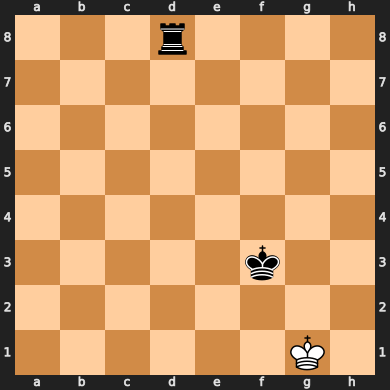

In [ ]:
b = chess.Board('3r4/8/8/8/8/5k2/8/6K1 w - -')
print(list(b.legal_moves))
b

In [ ]:
def test():
    s = set()
    for i in range(400000*64*10):
        s.add(f'3r4/8/8/8/8/5k2/8/6K1 w - {i}')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6e34dfb-c85e-40db-bde6-d0ca8b0148c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>